In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter
from AnchorOptimalProjector import *

In [2]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [3]:
def load_model_data(model, var, path='../data/'):
    # Loading data file
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    tas_array = ds[var].values
    # Close the dataset
    ds.close()
    return tas_array

def get_data_shape_lat_lon(model='CanESM5', var='tas', path='../data/'):
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    shape = ds[var].values.shape
    # Close the dataset
    ds.close()
    return shape, ds['lat'], ds['lon']

def regionalMeanTemperature(simulations, n_lat=2, n_lon=2, window_size=10):
    """
    Calculate the regional mean temperature and its smoothed internal variability.

    Parameters:
        simulations (array-like): 4D array of model simulations with dimensions (ensemble_members, years, latitudes, longitudes).
        n_lat (int): Number of latitude divisions.
        n_lon (int): Number of longitude divisions.
        window_size (int): Size of the moving average window.

    Returns:
        rmt (array-like): Regional mean temperature with dimensions (latitudes, longitudes).
        smoothed_riv (array-like): Smoothed regional internal variability with dimensions (latitudes, longitudes).
    """
    shape = simulations.shape
    # Reshape simulations to divide the globe into regions
    tas_regional = simulations.reshape(shape[0], shape[1], n_lat, shape[2] // n_lat, n_lon, shape[3] // n_lon)
    # Calculate regional mean temperature
    rmt = tas_regional.mean(axis=(0, 3, 5))
    # Calculate regional internal variability
    riv = rmt - tas_regional.mean(axis=(3, 5))
    # Create a 1D convolution kernel for the moving average
    kernel = np.ones(window_size) / window_size
    # Smooth the regional internal variability using a moving average
    smoothed_riv = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=1, arr=riv)
    return rmt, smoothed_riv

def load_data_models(models, var='tas', n_sample=10, path='../data/', coarse=12, window_size=10):
    X, y = None, None
    for model in models:
        tas_array = load_model_data(model, var=var, path=path)
        shape = tas_array.shape
        
        idxs = random.sample(range(shape[0]*shape[1]), n_sample)
        tas_regional = tas_array.reshape(shape[0], shape[1], shape[2]//coarse, coarse, shape[3]//coarse, coarse)
        X_temp = tas_regional.mean(axis=(3, 5))
        rmt = X_temp.mean(axis=0)
        # Calculate regional internal variability
        riv = rmt - X_temp
        # Create a 1D convolution kernel for the moving average
        kernel = np.ones(window_size) / window_size
        # Smooth the regional internal variability using a moving average
        A_temp = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=1, arr=riv)
            
            
        X_temp = X_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))
        y_temp = np.tile(tas_array.mean(axis=0), (shape[0], 1, 1)).reshape(shape[0]*shape[1], shape[2]*shape[3])
        A_temp = A_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))

        if X is None:
            X = X_temp[idxs,:]
            y = y_temp[idxs,:]
            A = A_temp[idxs, :] 
        else :
            X = np.vstack((X, X_temp[idxs,:]))
            y = np.vstack((y, y_temp[idxs,:]))
            A = np.vstack((A, A_temp[idxs,:]))
        del tas_array
        del X_temp
        del y_temp
        del A_temp
    return A, X, y

In [4]:
shape, lat, lon = get_data_shape_lat_lon()
d = shape[2]*shape[3]

In [5]:
B = 50
models_test = random.choices(models, k=B)
models_train = [[model for model in models if model != model_test ] for model_test in models_test ]

In [6]:
occurence_models_test = Counter(models_test)

In [7]:
occurence_models_test

Counter({'CanESM5': 9,
         'MPI-ESM1-2-LR': 5,
         'CESM2': 13,
         'MIROC6': 17,
         'MIROC-ES2L': 6})

In [8]:
N = 1000
n_alpha = 5
alphas = np.logspace(1, 3, n_alpha)
coarse = 24
n_cv = 2
gammas = [1, 2, 5]

In [9]:
try :
    directory = '../weights/'
    file = 'Anchor_weights_stability_n{}_coarse{}.pkl'.format(N, coarse)
    with open(directory + file, 'rb') as f:
        weights = pickle.load(f)
except:
    print('Weights does not exists!')
    
for model in models : 
    for gamma in gammas :
        if gamma not in weights[model].keys():
            weights[model][gamma] = None 

In [10]:
weights

{'CanESM5': {10: array([[ 0.0065351 ,  0.02502321,  0.02673558, ...,  0.03089107,
           0.03993629,  0.00106654],
         [ 0.00664878,  0.02504129,  0.02662624, ...,  0.03090291,
           0.03989529,  0.00109224],
         [ 0.00652901,  0.02531495,  0.02658739, ...,  0.03110101,
           0.03980157,  0.00111043],
         ...,
         [-0.00315608,  0.03489193,  0.07741243, ...,  0.11271574,
           0.09601201,  0.00051573],
         [-0.0031411 ,  0.03505316,  0.07695274, ...,  0.11255133,
           0.09606906,  0.00056106],
         [-0.00310361,  0.03527027,  0.07661786, ...,  0.11246133,
           0.09614974,  0.00056571]]),
  100: array([[-0.02635384,  0.01836868,  0.01239514, ...,  0.0177783 ,
           0.01654262,  0.00114484],
         [-0.02633073,  0.01820253,  0.01222201, ...,  0.01773368,
           0.01640056,  0.00117238],
         [-0.02672182,  0.01848132,  0.01204417, ...,  0.01790886,
           0.01621803,  0.00118847],
         ...,
         [-0.0

In [11]:

for i in tqdm(range(len(models_test))):
    m_train, m_test = models_train[i], models_test[i]
    #print('Fitting optimal ridge {}/{}'.format(i, B))
    print("Extracting data...", end='\r')
    A_train, X_train, Y_train = load_data_models(m_train, n_sample=N, coarse=coarse)
    A_test, X_test, Y_test = load_data_models([m_test], n_sample=N, coarse=coarse)
    print("Data extracted!")
    
    print('Transform training data with AOP...', end='\r')
    AOP = AnchorOptimalProjection(gamma=gammas)
    X_trains, Y_trains = AOP.fit_transform(A_train, X_train, Y_train)
    print('Data transformed!')
    
    for gamma in gammas:
        print(r"Training anchor ($\gamma$={:.1f})...".format(gamma), end='\r')
        ridge = RidgeCV(alphas=alphas, cv=n_cv) #cv=zip(idx_val, idx_val))
        ridge.fit(X_trains[gamma], Y_trains[gamma])
        print('Selected alpha : {}'.format(ridge.alpha_))
        print("Ridge regression fitted!")
        print('Saving weights...', end='\r')
        if weights[m_test][gamma] is None:
            weights[m_test][gamma] = np.hstack((ridge.coef_/occurence_models_test[m_test], (ridge.intercept_/occurence_models_test[m_test])[:,None]))
        else:
            weights[m_test][gamma] += np.hstack((ridge.coef_/occurence_models_test[m_test], (ridge.intercept_/occurence_models_test[m_test])[:,None]))
        print("Weights saved!")
# Save the weights for this alpha to a file
file_path = f'../weights/Anchor_weights_stability_n{N}_coarse{coarse}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(weights, f)

  0%|          | 0/50 [00:00<?, ?it/s]

Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


  2%|▏         | 1/50 [02:21<1:55:56, 141.97s/it]

Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


  4%|▍         | 2/50 [03:44<1:25:34, 106.97s/it]

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


  6%|▌         | 3/50 [05:05<1:14:37, 95.27s/it] 

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 100.0ma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 100.0ma$=2.0)...
Ridge regression fitted!
Weights saved!...


  8%|▊         | 4/50 [06:48<1:15:26, 98.40s/it]

Selected alpha : 100.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


 10%|█         | 5/50 [08:49<1:19:44, 106.33s/it]

Selected alpha : 10.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


 12%|█▏        | 6/50 [10:15<1:12:53, 99.39s/it] 

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 14%|█▍        | 7/50 [11:45<1:09:03, 96.35s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 100.0ma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 100.0ma$=2.0)...
Ridge regression fitted!
Weights saved!...


 16%|█▌        | 8/50 [13:13<1:05:40, 93.82s/it]

Selected alpha : 100.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


 18%|█▊        | 9/50 [14:42<1:02:55, 92.08s/it]

Selected alpha : 10.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


 20%|██        | 10/50 [16:10<1:00:39, 90.99s/it]

Selected alpha : 10.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 22%|██▏       | 11/50 [17:39<58:48, 90.47s/it]  

Selected alpha : 100.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...


 24%|██▍       | 12/50 [19:08<56:56, 89.90s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 26%|██▌       | 13/50 [20:37<55:13, 89.56s/it]

Selected alpha : 100.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


 28%|██▊       | 14/50 [22:06<53:36, 89.35s/it]

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 30%|███       | 15/50 [23:34<51:52, 88.94s/it]

Selected alpha : 100.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...


 32%|███▏      | 16/50 [25:03<50:25, 88.98s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 34%|███▍      | 17/50 [26:31<48:47, 88.70s/it]

Selected alpha : 100.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 36%|███▌      | 18/50 [28:01<47:32, 89.14s/it]

Selected alpha : 100.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...


 38%|███▊      | 19/50 [29:29<45:56, 88.93s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


 40%|████      | 20/50 [30:56<44:03, 88.12s/it]

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 100.0ma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 42%|████▏     | 21/50 [32:27<43:03, 89.09s/it]

Selected alpha : 10.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 44%|████▍     | 22/50 [33:55<41:23, 88.69s/it]

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 100.0ma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...


 46%|████▌     | 23/50 [35:25<40:06, 89.13s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 48%|████▊     | 24/50 [36:54<38:35, 89.06s/it]

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 50%|█████     | 25/50 [38:24<37:18, 89.52s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 52%|█████▏    | 26/50 [39:54<35:48, 89.50s/it]

Selected alpha : 100.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 54%|█████▍    | 27/50 [41:23<34:16, 89.40s/it]

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 56%|█████▌    | 28/50 [42:53<32:52, 89.68s/it]

Selected alpha : 100.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 58%|█████▊    | 29/50 [44:23<31:24, 89.74s/it]

Selected alpha : 100.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...


 60%|██████    | 30/50 [11:13:44<63:17:08, 11391.42s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 62%|██████▏   | 31/50 [11:15:20<42:14:07, 8002.50s/it] 

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 100.0ma$=2.0)...
Ridge regression fitted!
Weights saved!...


 64%|██████▍   | 32/50 [11:16:42<28:07:56, 5626.47s/it]

Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...


 66%|██████▌   | 33/50 [11:18:21<18:44:20, 3968.24s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...


 68%|██████▊   | 34/50 [11:19:55<12:28:16, 2806.02s/it]

Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


 70%|███████   | 35/50 [11:21:38<8:18:45, 1995.00s/it] 

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


 72%|███████▏  | 36/50 [11:23:25<5:33:21, 1428.68s/it]

Selected alpha : 10.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 100.0ma$=2.0)...
Ridge regression fitted!
Weights saved!...


 74%|███████▍  | 37/50 [11:25:06<3:43:13, 1030.29s/it]

Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 100.0ma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...


 76%|███████▌  | 38/50 [11:26:44<2:30:09, 750.77s/it] 

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


 78%|███████▊  | 39/50 [11:28:22<1:41:41, 554.71s/it]

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 100.0ma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 100.0ma$=2.0)...
Ridge regression fitted!
Weights saved!...


 80%|████████  | 40/50 [11:29:57<1:09:29, 416.98s/it]

Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 100.0ma$=2.0)...
Ridge regression fitted!
Weights saved!...


 82%|████████▏ | 41/50 [11:31:41<48:27, 323.06s/it]  

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


 84%|████████▍ | 42/50 [11:33:25<34:17, 257.14s/it]

Selected alpha : 10.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...


 86%|████████▌ | 43/50 [11:35:04<24:29, 209.92s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 88%|████████▊ | 44/50 [11:36:48<17:47, 177.95s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 100.0ma$=2.0)...
Ridge regression fitted!
Weights saved!...


 90%|█████████ | 45/50 [11:38:32<12:59, 155.90s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


 92%|█████████▏| 46/50 [11:40:09<09:13, 138.27s/it]

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 94%|█████████▍| 47/50 [11:41:49<06:19, 126.65s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 10.0mma$=1.0)...
Ridge regression fitted!
Weights saved!...
Selected alpha : 10.0mma$=2.0)...
Ridge regression fitted!
Weights saved!...


 96%|█████████▌| 48/50 [11:43:30<03:57, 118.97s/it]

Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...
Selected alpha : 316.22776601683796
Ridge regression fitted!
Weights saved!...


 98%|█████████▊| 49/50 [11:45:10<01:53, 113.22s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...
Selected alpha : 31.622776601683793
Ridge regression fitted!
Weights saved!...


100%|██████████| 50/50 [11:46:56<00:00, 848.33s/it]

Selected alpha : 100.0
Ridge regression fitted!
Weights saved!...


In [12]:
directory = '../weights/'
file = 'Anchor_weights_stability_n{}_coarse{}.pkl'.format(N, coarse)
with open(directory + file, 'rb') as f:
    weights = pickle.load(f)

In [13]:
R = 10
scores_pattern = {model:{gamma:[] for gamma in weights[model].keys()} for model in models}
for b in tqdm(range(R)):
    for model in models:
        for gamma in weights[model].keys():
            print("Extracting data...", end='\r')
            A_test, X_test, Y_test = load_data_models([model], var='tas', coarse=coarse, n_sample=N)
            print('Data extracted!')
            print("Predicting data ...", end='\r')
            A, B = weights[model][gamma][:,:-1], weights[model][gamma][:,-1]
            Y_pred = X_test @ A.T + B 
            print("Data predicted")
            print("Computing scores for ({} - {})".format(model, gamma), end='\r')
            score_pattern = r2_score(Y_test, Y_pred, multioutput='raw_values')
            scores_pattern[model][gamma].append(score_pattern)
            print("Score computed!")


  0%|          | 0/10 [00:00<?, ?it/s]

Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR

 10%|█         | 1/10 [02:58<26:46, 178.47s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s fo

 20%|██        | 2/10 [05:50<23:17, 174.65s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s fo

 30%|███       | 3/10 [08:50<20:38, 176.92s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s fo

 40%|████      | 4/10 [2:15:56<5:11:47, 3117.91s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s fo

 50%|█████     | 5/10 [2:19:25<2:52:25, 2069.07s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s fo

 60%|██████    | 6/10 [2:22:36<1:35:22, 1430.53s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s fo

 70%|███████   | 7/10 [2:25:37<51:05, 1021.82s/it]  

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s fo

 80%|████████  | 8/10 [2:28:39<25:08, 754.49s/it] 

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s fo

 90%|█████████ | 9/10 [2:31:41<09:35, 575.64s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 10)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 100000.0)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s fo

100%|██████████| 10/10 [2:34:35<00:00, 927.54s/it]

Score computed!


In [26]:
alpha=10

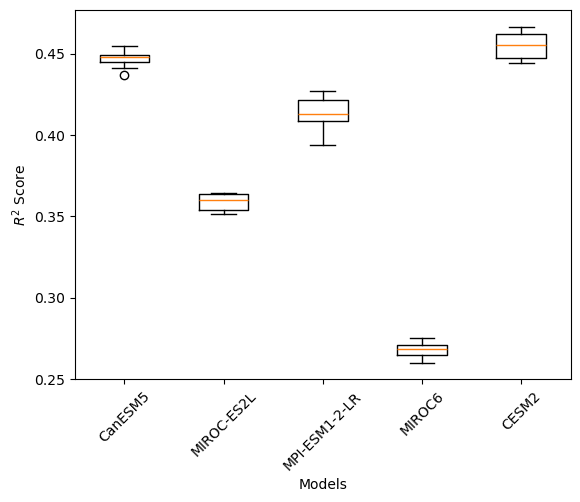

In [27]:
plt.boxplot([np.mean(scores_pattern[model][alpha], axis=1) for model in models])
# Boxplot
# Set xticklabels with alpha values
plt.xticks(range(1, len(models) + 1), [model for model in models], rotation=45)

# Set xlabel with alphas
plt.xlabel(r'Models')

# Set ylabel with r2 score
plt.ylabel(r'$R^2$ Score')

directory = '../Results'
plt.savefig(directory + "/R2_anchor{}_stability_coarse{}.pdf".format(gamma, coarse), format="pdf", bbox_inches="tight")

plt.show()

In [30]:
model = 'CanESM5'
scores_pattern_maps = np.mean(scores_pattern[model][alpha], axis=0).reshape(len(lat), len(lon))

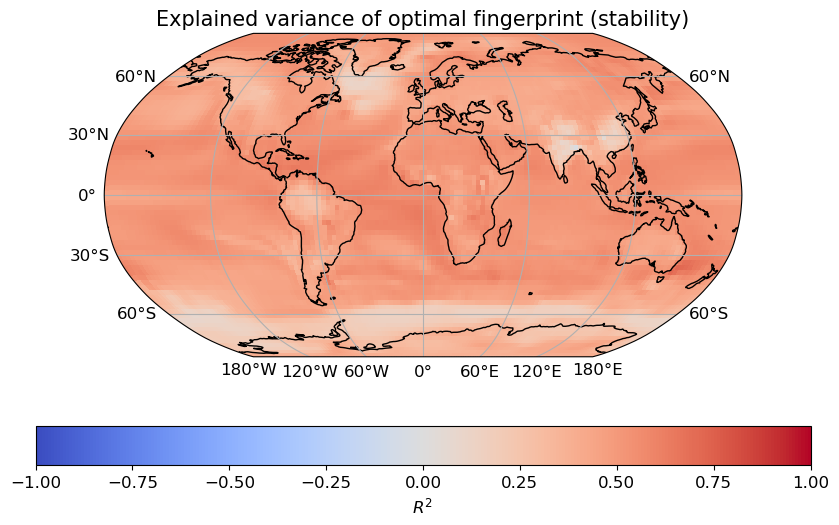

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm

# Assuming you have defined lat, lon, diff_r2_map, diff_corr_map, max_val_r2, max_val_corr

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot for diff_r2_map
norm_r2 = TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1)
contour_r2 = ax.pcolormesh(lon, lat, scores_pattern_maps, transform=ccrs.PlateCarree(), cmap='coolwarm', norm=norm_r2)
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}  # Longitude font size
gl.ylabel_style = {'size': 12}  # Latitude font size

ax.set_title(r'Explained variance of optimal fingerprint (stability)', fontsize=15)

cb = plt.colorbar(contour_r2, ax=ax, label='R2 score differences', orientation='horizontal')
cb.ax.tick_params(labelsize=12)
cb.set_label(r'$R^2$ ', fontsize=12) 

directory = '../Results'
plt.savefig(directory + "/maps_R2_anchor{}_stability_coarse_{}_{}.pdf".format(gamma, coarse, model), format="pdf", bbox_inches="tight")


plt.show()